In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter

In [27]:
def add_color(row, gene_segs):
    
    temp = gene_segs[gene_segs["POS"] > row["seg_start"]]
    temp = temp[temp["POS"] < row["seg_end"]]
    temp = temp[temp["CHROM"] == row["CHROM"]]
    if (len(temp)>0): 
        return Counter(temp["state_post"].map(plotting_assignments)).most_common()[0][0]
    return 'w'



plotting_assignments = {'amp_1_down':'#8b0100',
 'amp_1_up':'#8b0100',
 'amp_2_down':'#8b0100',
 'amp_2_up':'#8b0100',
 'bdel':'#1601ff',
 'del_1_down':'#07008b',
 'del_1_up':'#07008b',
 'del_2_down':'#07008b',
 'del_2_up':'#07008b',
 'loh_1_down':'#006300',
 'loh_1_up':'#006300',
 'loh_2_down':'#006300',
 'loh_2_up':'#006300',
 'neu':'w',
 'bamp': '#f98072'}

wgs_map = { 'GAIN':'#8a0702', #maroon
            'HLAMP': 'w',
            'NEUT': '#2800ff', #blue
            'AMP': '#f41707', #red
            'HETD': "#166401" #green
          }


pat = "708"
n_clones = 6
write_dir = 'numbat_wgs_export_files/'

segs = []
clones = []
for x in range(n_clones):
    segs.append(pd.read_csv(write_dir + pat+ "/numbat" + str(x+1) + "clone_segments.csv"))
    clones.append(pd.read_csv(write_dir + pat + "/numbat" + str(x+1) + "clone_gene_changes.csv"))

for x in range(len(segs)):
    segs[x]["color"] = segs[x].apply(lambda y: add_color(y, clones[x]), axis = 1)

    
wgs = pd.read_csv(write_dir +pat + "_wgs_segments.csv")


In [28]:
import numpy as np
segs[0]['log_transformed'] = np.log(segs[0]['phi_mle'])
segs[1]['log_transformed'] = np.log(segs[1]['phi_mle'])
segs[2]['log_transformed'] = np.log(segs[2]['phi_mle'])


array([[<AxesSubplot:title={'center':'log_transformed'}>]], dtype=object)

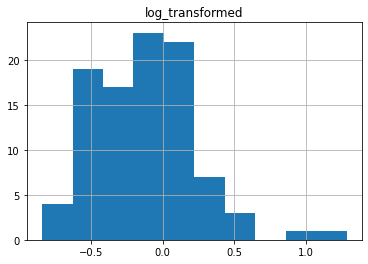

In [29]:
(segs[2]).hist('log_transformed')

In [30]:
chrom_min_max = []

for i in set(wgs["chr"]):
    mins = []
    maxs = []
    for x in segs:
        t = x[x["CHROM"] == i]
        mins.append(min(t["seg_start"]))
        maxs.append(min(t["seg_end"]))
    shorted_wgs = wgs[wgs["chr"] == i]
    mins.append(min(shorted_wgs["start"]))
    maxs.append(max(shorted_wgs["end"]))
    chrom_min_max.append((min(mins), max(maxs)))

wgs_split = []
segments_adj = []
for x in range(n_clones):
    segments_adj.append([])

for i in set(wgs["chr"]):
    off_set = 0 
    for j in range(i-1):
        off_set = off_set + chrom_min_max[j][1]
    j = 0
    for index in range(len(segs)):
        segments_full = segs[index]
        segments = segments_full[segments_full["CHROM"] == i]
        #segments["color"] = segments.apply(lambda y: add_color(y, x), axis = 1)
        segments["seg_start"] = segments["seg_start"] + off_set
        segments["seg_end"] = segments["seg_end"] + off_set
        segments_adj[index].append(segments)
        j = j+1
    shorted_wgs = wgs[wgs["chr"] == i]
    shorted_wgs["start"] =  shorted_wgs["start"] + off_set
    shorted_wgs["end"] =  shorted_wgs["end"] + off_set
    wgs_split.append(shorted_wgs)
    
final_segs = []
final_wgs = pd.concat(wgs_split)
for x in segments_adj:
    if len(x) >0:
        final_segs.append(pd.concat(x))
    else:
        final_segs.append(pd.DataFrame())

/tmp/ipykernel_2148/2520257715.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segments["seg_start"] = segments["seg_start"] + off_set
/tmp/ipykernel_2148/2520257715.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segments["seg_end"] = segments["seg_end"] + off_set
/tmp/ipykernel_2148/2520257715.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

([], [])

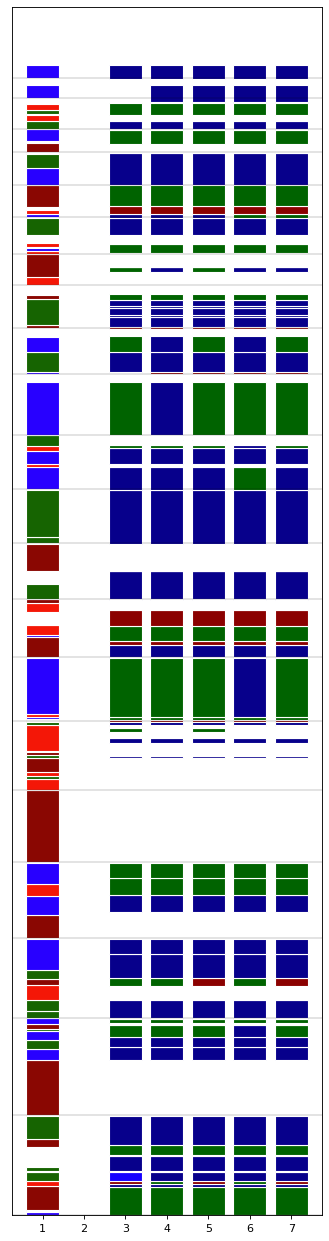

In [31]:
figure(figsize=(5, 20), dpi=80)

#PLOT WGS
plt.bar([1]*len(final_wgs), 
        final_wgs.end-final_wgs.start, bottom=final_wgs.start, color=
        final_wgs["event"].map(wgs_map), edgecolor='w')




for i,x in final_wgs.drop_duplicates(subset = "chr").iterrows():
    plt.axhline(y=x["start"], color='k', linestyle='-', xmin = 0, xmax = 1, linewidth = 0.2)
    
t = final_wgs[final_wgs["event"] == 'NEUT']



x_ax = 1.0/n_clones

plt.bar([n_clones+1]*len(t), 
        t.end-t.start, bottom=t.start, color=
        t["event"].map(wgs_map), edgecolor='w')

spot = 2
for clone in final_segs:
    plt.bar([spot]*len(clone), 
        clone.seg_end-clone.seg_start, bottom=clone.seg_start, color=
        clone["color"], edgecolor='w')
    spot = spot+1
plt.yticks([])
